# Sentiment Classification using Kaggle's IMDB Movie Scores Dataset

In this notebook I compare model performance among some common supervised and unsupervised sentiment classification methods using the well-known [Kaggle IMDB movie review dataset](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/notebooks). This dataset contains 50k movie reviews classified as either positive or negative reviews. Particularly, I adopt an applied approach focusing on model specification and hyperparameter selection to maximize classification accuracy with this dataset, rather than going into the technical details of each method.

In [1]:
import pandas as pd
import json, warnings, nltk, multiprocessing, caffeine, random
from scipy import stats
from collections import defaultdict
from tqdm import tqdm
import numpy as np
from time import time
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.model_selection import train_test_split
from clean_text import clean_text

# NLP modules
#nltk.download('wordnet') #  Necessary for first use
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

import tensorflow as tf
tf.compat.v1.disable_eager_execution() # addresses this issue: https://github.com/tensorflow/tensorflow/issues/38561
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPool1D, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
import gensim.models.keyedvectors as word2vec

# Performance metrics
from sklearn.metrics import confusion_matrix, roc_auc_score

pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)
warnings.simplefilter(action='ignore', category=FutureWarning,)

### Function for performance metrics

In [2]:
def metrics(y_true, y_pred):
    '''
    Calculates binary classification performance metrics for a given model.
    :param y_true: array_like, truth values as int
    :param y_pred: array_like, predicted values as int
    :returns: dict, with keys for each metric: 
        accuracy - proportion of correct predictions out of total predictions
        sensitivity - (aka recall), of all true positives reviews how many did we correctly predict as positive
        specificity - (aka selectivity/TNR), of all true negatives how many did we correctly predict as negative
        precision - of all predicted positive cases how many were actually positive
        F-1 score - harmonic/weighted mean of precision and sensitivity scores
        ROC-AUC - area under receiver operating characteristic curve
        
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    metrics_dict = {}
    metrics_dict['accuracy'] = round((tp + tn) / len(y_true), 4)
    metrics_dict['sensitivity'] = round(tp / (fn + tp), 4) # aka recall
    metrics_dict['specificity'] = round(tn / (tp + fp), 4) # aka TNR
    metrics_dict['precision'] = round(tp / (tp + fp), 4)
    metrics_dict['f1'] = round(2 * (metrics_dict['precision'] * metrics_dict['sensitivity']) \
                        / (metrics_dict['precision'] + metrics_dict['sensitivity']), 4)
    metrics_dict['roc_auc'] = round(roc_auc_score(y_true, y_pred), 4)
    
    return metrics_dict

### Read data

In [3]:
df = pd.read_csv('../data/IMDB Dataset.csv')
print(df.shape)
df.head(2)

(50000, 2)


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive


To make things easier, I create a new integer feature that converts the string positive/negative review.

In [4]:
df['positive_sent'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# EDA

### Class distribution

negative    25000
positive    25000
Name: sentiment, dtype: int64


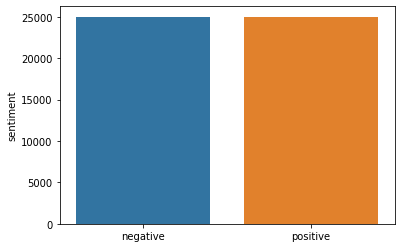

In [5]:
x = df.sentiment.value_counts()
sns.barplot(x.index, x)
print(x)

Classes are balanced in the data, meaning we can rely on all of the performance metrics above. If, for example, the data were highly imbalanced (e.g. nearly all positive or negative reviews), accuracy measures would provide little meaningful information. The reason being, it's mechanically easier to correctly predict the dominant class given its numerical abundance.

### Distribution of words by class

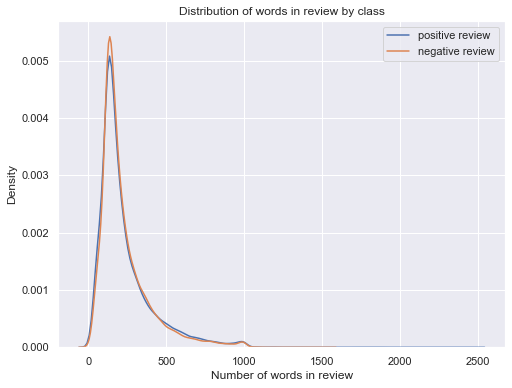

In [6]:
sns.set(rc={'figure.figsize':(8,6)})
positive = df[df.sentiment=='positive']['review'].str.split().map(lambda x: len(x)) # pd.Series with total word count per row
negative = df[df.sentiment=='negative']['review'].str.split().map(lambda x: len(x))
sns.kdeplot(positive, label='positive review') # kernel density plot
sns.kdeplot(negative, label='negative review')
plt.legend()
plt.title('Distribution of words in review by class')
plt.xlabel('Number of words in review')
plt.show()

Are there apparent differences in the number of words used in positive versus negative reviews? Not a lot, though the mass of negative reviews is slightly more concentrated (i.e. higher) on the left, indicating negative reviews are somewhat shorter. We see this below.

In [7]:
print(round(positive.mean(), 2), 'positive review')
print(round(negative.mean(), 2), 'negative review')
print(round(positive.mean() - negative.mean(), 2), 'word difference')

232.85 positive review
229.46 negative review
3.38 word difference


### Distribution of characters in review by class

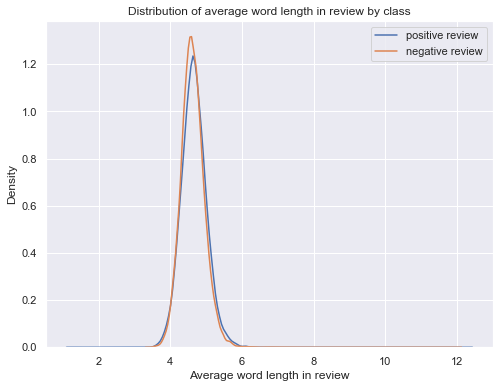

In [8]:
positive = df[df['sentiment']=='positive']['review'].str.split().apply(lambda x : [len(i) for i in x]) # pd.Series with list of individual word lengths per row
negative = df[df['sentiment']=='negative']['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.kdeplot(positive.map(lambda x: np.mean(x)), label='positive review')
sns.kdeplot(negative.map(lambda x: np.mean(x)), label='negative review')
plt.legend()
plt.title('Distribution of average word length in review by class')
plt.xlabel('Average word length in review')
plt.show()

In [9]:
positive = positive.map(lambda x: np.mean(x)) # pd.Series where each row is average word length per row
negative = negative.map(lambda x: np.mean(x))
print(round(positive.mean(), 2), 'positive review')
print(round(negative.mean(), 2), 'negative review')
print(round(positive.mean() - negative.mean(), 2), 'word difference')

4.66 positive review
4.62 negative review
0.03 word difference


We see that negative reviews tend to use slightly shorter words, on average, than positive reviews.

# Data cleaning

I clean the reviewer text data with `clean_text`, a class I created that among other things removes non-characters (e.g. URLs, emojis), removes contractions, lowercases words, removes punctuation, converts numbers to characters, and removes stopwords. Optionally, it can lemmatize words, correct spelling, enforce a minimum character length of words, or enforce a minimum word frequency.

In [10]:
start = time()
clean = clean_text().run(df['review'], lemmatize=False)
print('Total cleaning run time:', round(time() - start, 0), 'seconds')

Total cleaning run time: 69.0 seconds


In [11]:
print('Review, original: \n', df['review'].head(1).values[0])
print('\nReview, cleaned: \n', clean.head(1).values[0])

Review, original: 
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the sh

### Word frequency

Having removed English stopwords from the text (e.g. me, they, be), let's explore word frequency in order to remove words below a certain threshold frequency. As shown below, there are 144,917 unique words in this dataset. Of these, 73,308 appear only once. Most of these are misspellings or simply irregular words and hence best removed, which I do below.

In [12]:
def count_word_freq(series):
    '''
    Counts word frequency across all documents (rows) in a pd.Series.
    :param series: pd.Series
    :returns: pd.DataFrame, where index is each unique word in corpus and column is count of
        the occurrence of that word across all documents.
    '''
    temp = [i.split() for i in series] 
    freq = defaultdict(int)  # Get freq of each word across all documents
    for indiv_doc in temp:
        for token in indiv_doc:
            freq[token] += 1
        
    word_freq = pd.DataFrame.from_dict(freq, orient='index')\
        .reset_index().rename(columns={'index': 'word', 0: 'freq'})
    return word_freq

In [13]:
word_freq = count_word_freq(clean)

In [14]:
print(word_freq['freq'].describe())

count    144917.000000
mean         41.037063
std         536.498508
min           1.000000
25%           1.000000
50%           1.000000
75%           6.000000
max       85848.000000
Name: freq, dtype: float64


In [15]:
print(f"Number of words that appear only once in corpus: {len(word_freq[word_freq['freq']==1])}")

Number of words that appear only once in corpus: 73308


In [16]:
print('Some examples of rare words:')
word_freq[word_freq['freq']==1]['word'].head(10)

Some examples of rare words:


140      oldtimebbc
155          polari
197      halliwells
315          petter
376        discerns
431       dressedup
522      guesthosts
525    handselected
681       finsished
692         schemed
Name: word, dtype: object

In [17]:
# Keep words if used >=5 time across corpus
clean_min5 = clean_text().remove_infreq_words(clean, min_word_freq=5)

In [18]:
print('Resulting number of words that appear 5+ times in corpus: {:,}'.format(len(count_word_freq(clean_min5))))

Resulting number of words that appear 5+ times in corpus: 38,179


### Lemmatization

Finally, I *lemmatize* words, e.g. convert plural nouns to singular, infinitive verbs to present tense. I use NLTK's part-of-speech tagger that classifies words into their part of speech (e.g. adjective, adverb) and then lematizes the word. I prefer lemmatization to [stemming](https://medium.com/@tusharsri/nlp-a-quick-guide-to-stemming-60f1ca5db49e) as the latter typically yields less accurate results due to declination or conjugation of words for their particular part-of-speech use \([source](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)\).

In [19]:
start = time()
df['review_clean'] = clean_text().lematizer(clean_min5)
print('Total cleaning run time:', round(time() - start, 0), 'seconds')

Total cleaning run time: 806.0 seconds


In [20]:
total_words = len(count_word_freq(df['review_clean']))
print('Resulting number of words after lemmatization: {:,}'.format(total_words))

Resulting number of words after lemmatization: 29,518


### Train-test split

To evaluate model performance on unseen data, we split the data into train and test sets using scikit-learn's `train_test_split` method. Both the original, unprocessed review is included alongside the cleaned review. 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df[['review', 'review_clean']], 
                                                    df['positive_sent'], test_size=0.05, 
                                                    random_state=999)

In [22]:
print(X_train.shape)
print(X_test.shape)

(47500, 2)
(2500, 2)


In [23]:
print(y_train.mean())
print(y_test.mean())

0.5001473684210527
0.4972


# Unsupervised sentiment classification

Unsupervised learning is a family of machine learning algorithms that use data with no existing truth labels. Although the IMDB dataset contains truth labels, for later comparison with better-known supervised NLP algorithms (e.g. Naive Bayes, LSTM) I generate predictions using two unsupervised sentiment analysis algorithms: VADER and TextBlob. In particular, because these two algorithms are lexicon- rather than learning-based, I calculate predictions directly for the test subset.

## Valence Aware Dictionary and sEntiment Reasoner (VADER)

VADER is a popular a rule/lexicon-based sentiment analyzer. Lexicon approaches use a pre-defined dictionary of words and phrases, which are rated for polarity and intensity. VADER's lexicon contains about 7,500 sentiment features, which are scored each scored between extremely negative [-4] to extremely positive [+4]) by a panel human experts. Words not included in the lexicon are awarded a neutral sentiment of 0. VADER also makes use of the grammatical structure of documents (e.g. punctuation, capitalization, contrasting conjunctions). To calculate the compound sentiment score of a given document, VADER calculates the sum of the sentiment of all features in that document, and normalizes to [-1, 1] \([source](https://medium.com/ro-data-team-blog/nlp-how-does-nltk-vader-calculate-sentiment-6c32d0f5046b)\). Further information and source code can be found at VADER's [GitHub](https://github.com/cjhutto/vaderSentiment).

In [24]:
sid = SentimentIntensityAnalyzer() # instantiate VADER

NLTK's VADER accepts documents as a string; thus, we must iterate individually over each document in the corpus. For each document, `SentimentIntensityAnalyzer`'s `polarity_scores` returns a dictionary of length four. I focus on the last key, `compound`, which offers the normalized polarity (sentiment) score. Because VADER is built to calculate sentiment from the grammatical structure of documents, I calculate sentiment scores using the original, raw reviews.

In [25]:
print(sid.polarity_scores(X_test['review'].values[0]))
print("Actual rating:", y_test.iloc[0], '(negative)')

{'neg': 0.183, 'neu': 0.77, 'pos': 0.048, 'compound': -0.9627}
Actual rating: 0 (negative)


In [26]:
start = time()
lst = []
for i in range(len(X_test)):
    pred = sid.polarity_scores(X_test.iloc[i].values[0])['compound']
    lst.append(pred)
vader = pd.Series(lst, index=y_test.index)
print('Total model run time:', round(time() - start, 0), 'seconds')

Total model run time: 6.0 seconds


Finally, because this is a classification exercise (i.e. the truth values are categories, not continuous sentiment values), we convert positive sentiment scores to 1 and negative scores to 0.

In [27]:
vader = np.where(vader > 0, 1, 0)

In [28]:
metrics_dict = {}
metrics_dict['vader'] = metrics(y_test, vader)

In [29]:
print('VADER performance:')
for key, value in metrics_dict['vader'].items():
    print(key, ':', value)

VADER performance:
accuracy : 0.7072
sensitivity : 0.8673
specificity : 0.4195
precision : 0.6553
f1 : 0.7465
roc_auc : 0.7081


Out-of-the-box VADER performs well in classifying sentiment scores with these data. It correctly classifies the sentiment in 70.72% of reviews in the test set. VADER's performance, however, differs considerably between positive and negative reviews. On the one hand, it correctly classifies 86.73% of all positive reviews; yet on the other, it only correctly classifies 41.95% of negative reviews. If one were particularly interested in positive or negative reviews it would be advisable to adjust the classifer threshold using a precision-recall curve and/or F-score. For parsimony, and because the goal of this exercise is accuracy performance, I forego this additional step.

## TextBlob

TextBlob is an NLP library offering a host of tools, including parts-of-speech tagging, sentiment analysis, and noun phrase extraction, among others. Further information and source code can be found at TextBlob's [GitHub](https://github.com/sloria/textblob). 

Like VADER, TextBlob accepts individual documents as strings, meaning we must iterate over all documents to calculate a sentiment vector. `TextBlob().sentiment` returns a namedtuple, where the first element is the polarity (sentiment) score with a range [-1.0, 1.0] and the second is the subjectivity score with range [0.0, 1.0]. Since TextBlob is built to handle raw text, we use the original, raw reviews to generate predictions.


In [30]:
print(TextBlob(X_test.iloc[0].values[0]).sentiment)
print("Actual rating:", y_test.iloc[0], '(negative)')

Sentiment(polarity=-0.3326785714285715, subjectivity=0.567202380952381)
Actual rating: 0 (negative)


In [31]:
start = time()
lst = []
for i in range(len(X_test)):
    pred = TextBlob(X_test.iloc[i].values[0]).sentiment.polarity
    lst.append(pred)
textblob = pd.Series(lst, index=y_test.index).apply(lambda x: 1 if x > 0 else 0)
print('Total model run time:', round(time() - start, 0), 'seconds')

Total model run time: 4.0 seconds


In [32]:
metrics_dict['textblob'] = metrics(y_test, textblob)

In [33]:
print('TextBlob performance:')
for key, value in metrics_dict['textblob'].items():
    print(key, ':', value)

TextBlob performance:
accuracy : 0.6852
sensitivity : 0.9356
specificity : 0.2941
precision : 0.6219
f1 : 0.7472
roc_auc : 0.6866


As with VADER, TextBlob performs well with no tuning. TextBlob's accuracy is marginally worse than VADER. Even more than VADER though, we see large performance differences between classes; while the model correctly classifies about 94% of positive reviews, it only correctly classifies 29% of negative reviews.

# Supervised sentiment classification

## Naive Bayes classifier

Naive Bayes is a family of simple, supervised learning algorithms that use Bayes' theorem combined with a strong "naive" assumption of conditional independence between features given the value of the outcome variable. Although this assumption is frequently violated in many real-world applications, naive Bayes algorithms often work well as classifiers (e.g. especially in document classification and spam filtering), though they tend to be poor estimators. An explanation for this paradox can be found [here](https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf); essentially, the answer lies in the distribution of dependence within a class often cancelling each other out. Compared to more sophisticiated classifiers, naive Bayes classifiers are extremely fast and scalable \([source](https://scikit-learn.org/stable/modules/naive_bayes.html)\).

This naive Bayes classifier model is based on a "bag of words" (BOW) approach, which converts text (words or word combinations) into numerical representation for analysis. The BOW approach, however, only focuses on the number of times a given word appears in a document, not the order of words (as compared to more sophisticiated context-dependent algorithms like BERT). Specifically, I use sklearn's `CountVectorizer`, which counts the number of tokens present  per document among all tokens in the corpus. By default, `CountVectorizer` removes punctuation and changes words lowercase; I also remove non-alphanumeric characters with NLTK's regex tokenizer and English stopwords.

Because there is per-se no default algorithm for sklearn's Naive Bayes API, I began by comparing model performance across algorithms. I also experiment with two other hyperparameter n-gram, and vectorizer.

### Hyperparameter: Naive Bayes algorithm

In [34]:
cv = CountVectorizer(stop_words='english', ngram_range=(1,1), 
            tokenizer=RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize) # monogram
train_counts = cv.fit_transform(X_train['review_clean']) # scipy.sparse.csr.csr_matrix
test_counts = cv.transform(X_test['review_clean']) # use `transform` instead of `fit_transform` to ensure same feature dims

In [35]:
start = time()
BNB = BernoulliNB()
BNB.fit(train_counts, y_train)
bern_predictions = BNB.predict(test_counts) # returns np.ndarray
print('Total model run time:', round(time() - start, 0), 'seconds')

start = time()
MNB = MultinomialNB()
MNB.fit(train_counts, y_train)
mult_predictions = MNB.predict(test_counts) # returns np.ndarray
print('Total model run time:', round(time() - start, 0), 'seconds')

Total model run time: 0.0 seconds
Total model run time: 0.0 seconds


In [36]:
print("BernoulliNB performance:")
for key, value in metrics(y_test, bern_predictions).items():
    print(key, ':', value)
    
print("\nMultinomialNB performance:")
for key, value in metrics(y_test, mult_predictions).items():
    print(key, ':', value)

BernoulliNB performance:
accuracy : 0.8556
sensitivity : 0.8222
specificity : 0.9613
precision : 0.8795
f1 : 0.8499
roc_auc : 0.8554

MultinomialNB performance:
accuracy : 0.8608
sensitivity : 0.8399
specificity : 0.9288
precision : 0.8751
f1 : 0.8571
roc_auc : 0.8607


True to form, the naive Bayes model trains very quickly and exhibits decent classification performance! Performance between the Bernoulli and Multinomial classifiers are very similar; I'll call it for Multinomial. 

### Hyperparmeter: N-gram

In [37]:
cv = CountVectorizer(stop_words='english', ngram_range=(2,2), 
            tokenizer=RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize) # bigram
train_counts = cv.fit_transform(X_train['review_clean']) 
test_counts = cv.transform(X_test['review_clean'])
MNB = MultinomialNB()
MNB.fit(train_counts, y_train)
mult_predictions_ngram = MNB.predict(test_counts) 
for key, value in metrics(y_test, mult_predictions_ngram).items():
    print(key, ':', value)

accuracy : 0.872
sensitivity : 0.856
specificity : 0.9261
precision : 0.883
f1 : 0.8693
roc_auc : 0.8719


Increasing from monograms to bigrams raised accuracy about one percentage point! Supplementary analyses showed performance decreased with trigrams, so we'll stick with bigrams.

### Hyperparameter: Vectorizer (TF-IDF)

In [38]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(2,2), 
            tokenizer=RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize) 
train_counts = tfidf.fit_transform(X_train['review_clean']) 
test_counts = tfidf.transform(X_test['review_clean'])
MNB = MultinomialNB()
MNB.fit(train_counts, y_train)
mult_predictions_tfidf = MNB.predict(test_counts)
for key, value in metrics(y_test, mult_predictions_tfidf).items():
    print(key, ':', value)

accuracy : 0.8764
sensitivity : 0.86
specificity : 0.9319
precision : 0.8879
f1 : 0.8737
roc_auc : 0.8763


Term frequency-inverse document frequency (TF-IDF) is a statistic reflecting the importance of a word in a document, defined by the number of times a word appears in a document compared to the number of documents containing the word. For a helpful introduction see [this article](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089). Using sklearn's `TfidfVectorizer` accuracy increases about 0.4 percentage points. We'll call this our final naive Bayes model.

Notably, naive Bayes performs much better than TextBlob or VADER, accurately classifying 87.64% of reviews, which is 16.92 percentage points higher than the VADER model. Moreover, the naive Bayes model performs well with both classes, correctly classifying 86% of positive reviews and 93.19% of negative reviews.

In [39]:
metrics_dict['naive_bayes'] = metrics(y_test, mult_predictions_tfidf)

## Word Embeddings and (Bidirectional-) LSTM

Word embeddings are dense, distributed real-value vector representations of words, which are often tens or hundreds of dimensions. Each dimension can be thought of as an abstract feature that captures semantic, contextual, and syntactic meanings of words based on their learned usage \([source](https://medium.com/@b.terryjack/nlp-everything-about-word-embeddings-9ea21f51ccfe)\). These dense vector representations contrast with a sparse one-hot vector representations of words (e.g. `CountVectorizer`), which are not only a computationally inefficient way to represent data, but unable to capture the similarity of words as they represent words as independent. Word embeddings allow easy comparison of the similarity of words (e.g. man::woman, king::queen) using measures such as cosine similarity, Euclidean distance, and Jaccard distance (for examples, [see](https://towardsdatascience.com/calculating-document-similarities-using-bert-and-other-models-b2c1a29c9630)). Word embeddings can be learned from a given training set using a host of algorithms; alternatively, users can utilize *pretrained word embeddings* that have been trained using a much larger corpous than is available to most users (e.g. the entire English-language Wikipedia). Pretrained word embeddings are an example of *transfer learning*, i.e. training a supervised model in one task in one domain and applying that trained model to a related task or domain \([source](https://ruder.io/transfer-learning/)\). This approach can not only vastly speed up training time, but also reduces problems associated with modeling a small corpus. In this portion of the notebook, I train a deep learning model with three popular (pretrained) word embeddings, allowing me to compare their performance on the IMDB dataset. Specifically, I use: [Word2Vec](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa), [GloVe](https://nlp.stanford.edu/projects/glove/), and [fastText](https://fasttext.cc/). I also train a baseline model with no pretrained word embedding and compare performance to these pretrained embeddings.

**Word2Vec**<br>
Originally proposed by [Thomas Mikolov and colleagues at Google in 2013](https://arxiv.org/pdf/1310.4546.pdf), Word2Vec is built upon a shallow, 1-hidden-layer feed-forward neural network that relies on one of two architectures: *continuous bag-of-words (CBOW)* or *continuous skip-gram*. Whereas CBOW approach models the target (middle) word given the surrounding context words, skip-gram models the context words given the current word in a sentence. Both approaches require specification of the *context window*, or the number of adjacent words (typically 5-10), to infer the similarity of words. In practice, CBOW trains faster and often has better representations for common words, though skip-gram is better for infrequent words. I use Word2Vec embeddings trained on the Google News dataset (~100 billion words), containing 300-dimensional vectors for 3 million words and phrases, available from [Google](https://code.google.com/archive/p/word2vec/). These embeddings were constructed using a skip-gram architecture and negative sampling (for details, [see](https://arxiv.org/pdf/1310.4546.pdf)).

**Global Vectors (GloVe)**<br>
Proposed in 2014 by [Stanford researchers](https://nlp.stanford.edu/pubs/glove.pdf), GloVe offers a different word embedding approach using matrix factorization. Unlike Word2Vec, which infers word meaning based only on local contextual information of words, GloVe relies on both local and *global* word context by aggregating word-word co-occurrence for a corpus (see [this article](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010) for a more in-depth explanation). The authors of GloVe argue their approach allows this method to better differentiate the specific meaning of words among related words ([source](https://nlp.stanford.edu/projects/glove//)). I use the 300-dimension variant trained using the entire 2014 English Wikipedia website plus [Gigaword5](https://catalog.ldc.upenn.edu/LDC2011T07), which together comprise about 6 billion words, yielding a file of 400k unique words. This file can be downloaded [here](https://nlp.stanford.edu/projects/glove/).

**fastText**<br>
Developed in 2016 by [Facebook's AI Research lab](https://arxiv.org/abs/1607.04606), fastText builds on the skip-gram architecture of Word2Vec. Whereas Word2Vec and GloVe rely only the word itself to construct embeddings, the fastText API also allows each word to be represented as a bag of character n-grams. For example, with an n-gram length of 3 the word "squid" is into "<sq", "squ", "qui", "uid", and "id>". "<" and ">" are word boundaries, allowing the algorithm to distinguish other words in the vocabulary, such as "\<id\>". In particular, this enhances performance for rare words and also enables the embeddings to capture prefixes and suffixes ([source](https://towardsdatascience.com/fasttext-under-the-hood-11efc57b2b3)). To conduct an apples-to-apples comparison, however, I only make use of the base word embeddings contained in the fastText file. I use the 300-dimension variant trained on the 2017 English Wikipedia website, which contains about 16 billion words, yielding a file containing 1 million words. This file can be downloaded [here](https://fasttext.cc/docs/en/english-vectors.html).

**LSTM**<br>
Word vectors cannot be directly used to classify sentiment (or any other modeled outcome). Generally, researchers use these vector representations as an input to a stand-alone supervised learning model. In particular, because text data contain temporal dependencies between words in the same document, [recurrent neural networks (RNNs)](https://towardsdatascience.com/recurrent-neural-networks-d4642c9bc7ce) are best suited to this task. Although it is possible to capture time dependencies with tree-based and feedforward neural networks with properly-engineered features, RNNs are explicitly designed to capture such time dependencies. RNNs act by sharing information from upstream inputs via a *hidden state*, providing that information to downstream inputs. Esssentially, RNNs loop through downstream (and potentially upstream) timestamps passing forward/backward this information. I use a variant of a RNN called [long short-term memory (LSTM)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), which is specifically designed to learn these long-term dependencies. The core idea of LSTMs is the *cell state* (i.e. LSTM's variant of the hidden state), which allows information to potentially flow through unchanged. Information is added or removed from the cell state by a series of *gates* (e.g. an "input gate", "output gate", and "forget gate"). It's common to compare performance of an LSTM model to a [gated recurrent unit [GRU]](https://medium.com/mindboard/lstm-vs-gru-experimental-comparison-955820c21e8b) model. Separate analyses revealed performance for all embeddings types was very similar, so for this reason I stick with LSTM.
    
**Bidirectional-LSTM**<br>
By default, LSTM/RNNs are *unidirectional*, i.e. only *past* information is provided to future timestamps. While this architecture is suitable for many time series modeling exercises, for some language modeling exercises this can be a shortcoming. Because meaning is gleaned from both upstream and downstream words in textual data, it is often advantageous to use a [bidirectional](https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks) recurrent architecture, which connects two hidden recurrent layers: a forward- and a backward-layer. Perhaps unsurprisingly, using a bidirectional (LSTM) layer drastically improved performance, compared to a undirectional LSTM layer, as supplementary results showed.

### Preparation

Compared to earlier NLP methods, feeding text data to a neural network involves a few more preprocessing steps.

#### Embedding dictionary 

The first step is to create an embedding dictionary containing each word in the corresponding pretrained word embeddings file (Word2Vec, GloVe, and fastText). For maximum performance I use the 300d variant for each word embedding type.

In [40]:
def get_word_embeddings(word_embeddings_name):
    '''
    Reads in pretrained word embeddings, returns embeddings dictionary
    :param word_embeddings_name: str, name of particular word embeddings to read from disk
    :returns: dict, embeddings dictionary where each key corresponds to a word and the value
        associated with that word is a (300,) numpy.ndarray of word vectors.
    '''
    
    if word_embeddings_name == 'glove':
        path = '../data/glove.6B/glove.6B.300d.txt'
    elif word_embeddings_name == 'word2vec':
        word2vec_embeddings = word2vec.KeyedVectors.load_word2vec_format("../data/word2vec/GoogleNews-vectors-negative300.bin", binary=True)
    elif word_embeddings_name == 'fasttext':
        path = '../data/fasttext/wiki-news-300d-1M.vec'
    else:
        raise ValueError('Word embeddings name unrecognized!')
    
    if(word_embeddings_name == 'glove' or word_embeddings_name == 'fasttext'):
        embedding_dict = {}
        with open(path, 'r') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vectors = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vectors
            f.close()
        
    else:
        embedding_dict = {}
        for word in word2vec_embeddings.vocab:
            embedding_dict[word] = word2vec_embeddings.word_vec(word)
    
    print("Embedding dictionary contains {:,} unique entries".format(len(embedding_dict.keys())))
    
    return embedding_dict

#### Embedding matrix

Next, I create an embedding matrix, which will be used in the input layer of a deep learning model. This is a 29,445 x 300 matrix, where the number of rows corresponds to the number of unique words in `X_train` (plus 1 for out-of-vocabulary [OOV] words) and the number of columns corresponds to the number of embedding dimensions. Intiutively, I loop through all unique words in the training set, selecting only the word vectors corresponding to these words. An alternative, less efficient approach would be to use all words and their embeddings in word embeddings file; however, the number of words in `X_train` is only a fraction of each embedding file. 

In [41]:
def create_embedding_matrix(embedding_dict, word_index, vector_dims = 300):
    '''
    Creates embedding matrix that will be used as constant weights in the embedding layer
        of our deep learning model. 
    :param embedding_dict: dict, embeddings dictionary
    :param word_index: dict, word-to-index dictionary
    :param vector_dims: int, number of vector dimensions in embedding dictionary
    :returns: numpy.ndarray, where row count is number of unique words in X_train and columns
        count is number of vector dimensions
    '''
    num_words = len(word_index) + 1 # number of unique words in corpus +1 for reserved 0 index
    embedding_matrix = np.zeros((num_words, vector_dims))

    for word, i in tqdm(word_index.items()):
        if i > num_words:
            continue
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec
    
    return embedding_matrix

#### Tokenize words via hashmap

The third step is to tokenize each document in the corpus. We do this by creating a dictionary that maps each word in the corpus to a numeric index using Tensorflow's `Tokenizer` class. We then transform each document to a sequence of integers, where each integer maps to a key in the word-to-index dictionary. We provide this transformed list of lists to our deep learning models. 

In [42]:
def tokenize(x_train, x_test):
    '''
    Create a word-to-index dictionary (hashmap) that maps each word in corpus/dataframe to a key, with
        a numeric index (value) for each key. These values are represented in sequences.
    :param x_train: pd.Series, where each row is a cleaned review in X_train
    :param x_test: pd.Series, where each row is a cleaned review in X_test
    :returns:
        0) list of lists, where each sublist is a particular text row in cleaned data for X_train
        Elements in this sublist correspond to a value in the word-to-index dictionary, where
        key corresponds to word.
        1) list of lists, where each sublist is a particular text row in cleaned data for X_train
        2) word-to-index dictionary for X_train, where length if number of unique words in corpus
    '''
    tokenizer_obj = Tokenizer(oov_token='OOV') # keeps n-1 words, making token for out-of-vocab words (rather than setting as new token)
    tokenizer_obj.fit_on_texts(x_train)
    x_train_seq = tokenizer_obj.texts_to_sequences(x_train)
    x_test_seq = tokenizer_obj.texts_to_sequences(x_test)
    word_index = tokenizer_obj.word_index
    return x_train_seq, x_test_seq, word_index

In [43]:
X_train_seq, X_test_seq, word_index = tokenize(X_train['review_clean'], X_test['review_clean'])

In [44]:
# Example of first 5 words in row 1 of X_train
X_train_seq[0][:5]

[432, 1754, 101, 9908, 995]

#### Word padding

When training a deep learning model via minibatch gradient descent, tokenized sentence sequences must have the same number of timestamps (i.e. words) per minibatch. We use Tensorflow's `pad_sequences` method for this, truncating and padding excess words beyond a threshold with a value of zero.

In [45]:
def pad_words(sequence, maxlen=300):
    '''
    Transforms a list of length num_samples of sequences (i.e. list of integers) into 2D numpy array of shape
        (num_samples, maxlen). Individual words in a given sequence/list after maxlen are truncated. Short
        sequences are padded at the end with zeros so that all sequences have the same length.
    :param maxlen: int, maximum length of all sequences
    :return: Numpy 2D array of shape (num_samples, maxlen)
    '''
    return pad_sequences(sequence, maxlen=maxlen, truncating='post', padding='post')

There is considerable variation in the number of words per review even among the cleaned reviews (see below). We use the length of the longest review in X_train and pad all shorter reviews to this length.

In [46]:
print(round(X_train['review_clean'].str.split()\
            .map(lambda x: len(x)).describe(), 2))

count    47500.00
mean       115.75
std         87.08
min          3.00
25%         62.00
50%         86.00
75%        141.00
max       1341.00
Name: review_clean, dtype: float64


In [47]:
max_words_sequence = df['review_clean'].str.split().map(lambda x: len(x)).max()
X_train_pad = pad_words(X_train_seq, max_words_sequence)
X_test_pad = pad_words(X_test_seq, max_words_sequence)

#### Model performance

In [48]:
def plot_model_performance(model):
    '''
    Generates Matplotlib.pyplot line plot depicting training and validation set accuracy over each epoch.
    :param model: tensorflow.python.keras.engine.sequential.Sequential
    :returns: Matplotlib.pyplot line plot
    '''
    sns.set(rc={'figure.figsize':(8,6)})
    plt.plot(range(1,len(model.history.history['accuracy'])+1), model.history.history['accuracy'], label="Training")
    plt.plot(range(1,len(model.history.history['val_accuracy'])+1), model.history.history['val_accuracy'], label="Validation")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy")
    plt.title("Training and validation set accuracy by epoch")
    plt.ticklabel_format(style='plain', axis='x', useOffset=False)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.show()

#### Tensorflow Keras Sequential model

[Keras](https://keras.io/) is a high-level deep learning API built on top of Google's [Tensorflow](https://www.tensorflow.org/). Starting with Tensorflow 2, Keras is integrated into Tensorflow. I use a `Sequential` class model, which stacks layers linearly and accepts only one input tensor and outputs only one tensor. 

There are practically an infinite number of hyperparameter combinations to assess with neural networks. In supplementary analyses I experimented with the number of hidden layers, the type of hidden layer(s) (e.g. LSTM/GRU, bidirectional-LSTM/GRU, dense), the number of nodes per hidden layer, dropout among hidden layers (e.g. traditional dropout, convolutional dropout, recurrent dropout, spatial dropout), learning rate, and mini-batch size. Once it was clear what general model structure performed well (i.e. a modestly-sized bidirectional-LSTM layer, a smaller dense layer, and dropout layers) I used [Optuna](https://optuna.org/) to tune the hyperparameters that impacted performance most (i.e. nodes and dropout amounts) using the GloVe embeddings (results were similar for other pretrained word embeddings). **My goal was to find a model that performed reasonably well in order to compare the accuracy between word embeddings. In the resulting model, I train the same model varying only the word embeddings. Thus, to the extent in which we observe accuracy differences in the test set, this is attributable to the particular word embeddings**.

The first hidden layer is an `Embedding` layer. *For models using the pretrained embeddings, I initialize the weights in this layer using the word embeddings, setting this layer to non-trainable. For the "Base" model (i.e. no pretrained embeddings), the weights in this layer are initialized randomly and set to trainable*. Therefore while the pretrained embeddings are taken as fixed for the former, for the latter the model learns the word embeddings for this particular dataset. Importantly, the dimensions of this embedding layer are the same in all cases. Following this layer I use a `Bidirectional` layer combined with an `LSTM` layer, which include dropout and recurrent dropout. This returns a 3D tensor of shape (i.e. number_of_reviews_in_minibatch, words_per_review, embedding_dimensions). Next, I use a `GlobalMaxPool1D` layer, which reduces the data dimensionality from 3D to 2D with shape (number_of_reviews_in_minibatch, embedding_dimensions) by taking the maximum value along the time dimension. This is followed by a `Dropout` layer, a `Dense` (i.e. feedforward) layer, another dropout layer, and the output layer that uses a sigmoid activation. This activation function output the class *probability*. 

I use a binary cross-entropy loss function and an `Adam` optimizer with the default learning rate of 0.001. The number of training epochs is a critical hyperparameter. Too few epochs can result in underfitting, while too many can result in overfitting. Rather a-priori specify the number of training epochs I use `EarlyStopping`, which halts learning after performance in the validation set stops improving between epochs, resetting the weights from the best-performing epoch. I set a patience parameter of 2, meaning that if the validation loss continues to increase (i.e. generally, decreased accuracy) for two consecutive epochs the model halts training. I do, however, set a maximum number of epochs at 10. 

### Baseline: No pretrained word embeddings

In [49]:
clear_session() # clear previous Keras session graphs

base_model = Sequential()

base_model.add(Embedding(input_dim=len(word_index)+1, 
                  output_dim=300,
                  input_length=max_words_sequence,
                  trainable=True))

# Note - adding dropout in LSTM layer itself is equivalent to adding a dropout layer before

base_model.add(Bidirectional(LSTM(units=128, dropout=0.4, 
               recurrent_dropout=0.3, return_sequences=True))) # default activation tanh

base_model.add(GlobalMaxPool1D()) # takes max value over the three dimensions

base_model.add(Dropout(0.3))

base_model.add(Dense(64, activation='relu'))

base_model.add(Dropout(0.2))

# Output layer
base_model.add(Dense(1, activation='sigmoid')) # faster than softmax with two units

# Compile model
base_model.compile(loss='binary_crossentropy', 
     optimizer=Adam(learning_rate=0.001), 
     metrics=['accuracy'])

In [50]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1341, 300)         8833500   
_________________________________________________________________
bidirectional (Bidirectional (None, 1341, 256)         439296    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

Compared to the other LSTM models (below), the Base model has considerably more trainable parameters, owing to the trainable embedding layer. 

In [51]:
base_hist = base_model.fit(X_train_pad, 
              y_train, 
              batch_size=64, 
              validation_split=0.25,
              verbose=2,
              epochs=10,
              use_multiprocessing=True,
              callbacks=[EarlyStopping(patience=2, restore_best_weights=True)])

Train on 35625 samples, validate on 11875 samples
Epoch 1/10


/Users/josephking/PythonVirtualEnv/IMDB_movie_sentiment/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


35625/35625 - 3094s - loss: 0.3654 - accuracy: 0.8347 - val_loss: 0.2620 - val_accuracy: 0.8901
Epoch 2/10
35625/35625 - 2784s - loss: 0.1911 - accuracy: 0.9272 - val_loss: 0.2735 - val_accuracy: 0.8896
Epoch 3/10
35625/35625 - 2781s - loss: 0.1195 - accuracy: 0.9578 - val_loss: 0.3188 - val_accuracy: 0.8798


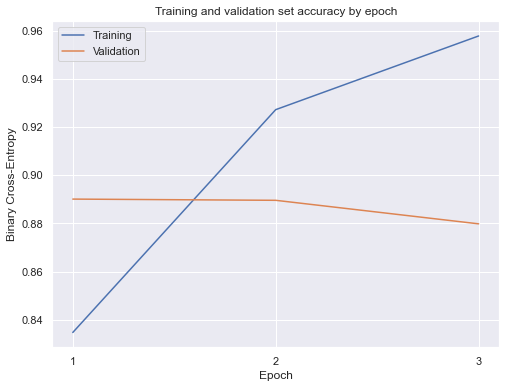

In [52]:
plot_model_performance(base_model)

In [53]:
pred_base = base_model.predict(X_test_pad).flatten() # flatten from 2d to 1d array
pred_base = pd.Series(pred_base).apply(lambda x: 1 if x > 0.5 else 0)
metrics_dict['base_lstm'] = metrics(y_test, pred_base)
print(metrics_dict['base_lstm'])

{'accuracy': 0.8976, 'sensitivity': 0.9075, 'specificity': 0.8794, 'precision': 0.8889, 'f1': 0.8981, 'roc_auc': 0.8977}


Despite not using any pretrained word embeddings, the baseline model performs quite well, correctly classifying 88.44% of reviews. This is only slightly better than our final naive Bayes model at 87.64%. The Base model likewise was significantly better at classifying positive reviews (93.56%) versus negative reviews (76.38%). Notably, however, the number of trainable parameters in this model leads to considerable overfitting. The best performance from the Base model was achieved in epoch one, after which performance stopped improving in the validation set (see above).

### Word2Vec embeddings

#### Embedding dictionary and embedding matrix

In [54]:
w2v_vector_dims = 300
w2v_embedding_dict = get_word_embeddings('word2vec')
w2v_embedding_matrix = create_embedding_matrix(w2v_embedding_dict, word_index, w2v_vector_dims)

 11%|█▏        | 3365/29444 [00:00<00:00, 33606.84it/s]

Embedding dictionary contains 3,000,000 unique entries


100%|██████████| 29444/29444 [00:00<00:00, 118454.93it/s]


#### Overlap between X_train and Word2Vec file

In [55]:
# Get tokens in X_test, simply to assess overlap
tokenizer_obj = Tokenizer(oov_token='OOV')
tokenizer_obj.fit_on_texts(X_test['review_clean'])
word_index_test = tokenizer_obj.word_index

In [56]:
intersection_train = [i for i in word_index.keys() if i in w2v_embedding_dict.keys()]
intersection_test = [i for i in word_index_test.keys() if i in w2v_embedding_dict.keys()]

print('Share of overlapping words in X_train: {}%'.format(round((len(intersection_train)/len(word_index)*100), 1)))
print('Share of overlapping words in X_test: {}%'.format(round((len(intersection_test)/len(word_index_test)*100), 1)))

Share of overlapping words in X_train: 75.2%
Share of overlapping words in X_test: 83.2%


One important factor in word embedding performance is the degree of overlap between the embedding file and the training and test datasets. The Word2Vec embeddings were trained using the Google News dataset, which has the least overlap of the three embeddings at 75% and 83% for the training and test sets, respectively.

#### Train a model using Word2Vec embeddings

In [57]:
clear_session()

w2v_model = Sequential()

w2v_model.add(Embedding(input_dim=len(word_index)+1, 
                  output_dim=w2v_vector_dims,
                  input_length=max_words_sequence, 
                  embeddings_initializer=Constant(w2v_embedding_matrix),
                  trainable=False))

w2v_model.add(Bidirectional(LSTM(units=128, dropout=0.4, 
               recurrent_dropout=0.3, return_sequences=True)))

w2v_model.add(GlobalMaxPool1D())

w2v_model.add(Dropout(0.3))

w2v_model.add(Dense(64, activation='relu'))

w2v_model.add(Dropout(0.2))

# Output layer
w2v_model.add(Dense(1, activation='sigmoid'))

# Compile model
w2v_model.compile(loss='binary_crossentropy', 
     optimizer=Adam(learning_rate=0.001), 
     metrics=['accuracy'])

In [58]:
w2v_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1341, 300)         8833500   
_________________________________________________________________
bidirectional (Bidirectional (None, 1341, 256)         439296    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

Explanation here..

In [59]:
w2v_hist = w2v_model.fit(X_train_pad, 
              y_train, 
              batch_size=64, 
              validation_split=0.25,
              verbose=2,
              epochs=10,
              use_multiprocessing=True,
              callbacks=[EarlyStopping(patience=2, restore_best_weights=True)])

Train on 35625 samples, validate on 11875 samples
Epoch 1/10


/Users/josephking/PythonVirtualEnv/IMDB_movie_sentiment/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


35625/35625 - 2256s - loss: 0.4011 - accuracy: 0.8175 - val_loss: 0.3185 - val_accuracy: 0.8701
Epoch 2/10
35625/35625 - 2258s - loss: 0.3316 - accuracy: 0.8574 - val_loss: 0.2957 - val_accuracy: 0.8734
Epoch 3/10
35625/35625 - 2256s - loss: 0.3045 - accuracy: 0.8718 - val_loss: 0.2817 - val_accuracy: 0.8819
Epoch 4/10
35625/35625 - 2189s - loss: 0.2869 - accuracy: 0.8792 - val_loss: 0.2846 - val_accuracy: 0.8808
Epoch 5/10
35625/35625 - 2198s - loss: 0.2734 - accuracy: 0.8866 - val_loss: 0.2607 - val_accuracy: 0.8891
Epoch 6/10
35625/35625 - 2206s - loss: 0.2586 - accuracy: 0.8934 - val_loss: 0.2572 - val_accuracy: 0.8925
Epoch 7/10
35625/35625 - 2207s - loss: 0.2472 - accuracy: 0.8991 - val_loss: 0.2589 - val_accuracy: 0.8925
Epoch 8/10
35625/35625 - 2205s - loss: 0.2377 - accuracy: 0.9025 - val_loss: 0.2532 - val_accuracy: 0.8953
Epoch 9/10
35625/35625 - 2213s - loss: 0.2578 - accuracy: 0.8932 - val_loss: 0.2584 - val_accuracy: 0.8909
Epoch 10/10
35625/35625 - 2218s - loss: 0.2406 -

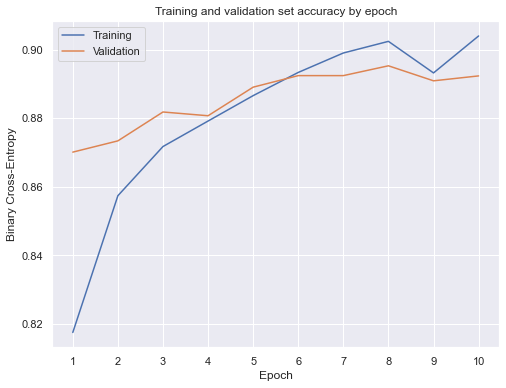

In [60]:
plot_model_performance(w2v_model)

In [61]:
pred_w2v = w2v_model.predict(X_test_pad).flatten() # flatten from 2d to 1d array
pred_w2v = pd.Series(pred_w2v).apply(lambda x: 1 if x > 0.5 else 0)
metrics_dict['w2v_lstm'] = metrics(y_test, pred_w2v)
print(metrics_dict['w2v_lstm'])

{'accuracy': 0.9024, 'sensitivity': 0.8842, 'specificity': 0.965, 'precision': 0.9166, 'f1': 0.9001, 'roc_auc': 0.9023}


Explanation...

### GloVe embeddings

In [62]:
glove_vector_dims = 300
glove_embedding_dict = get_word_embeddings('glove')
glove_embedding_matrix = create_embedding_matrix(glove_embedding_dict, word_index, glove_vector_dims)

 50%|████▉     | 14627/29444 [00:00<00:00, 74701.44it/s]

Embedding dictionary contains 400,001 unique entries


100%|██████████| 29444/29444 [00:00<00:00, 104661.83it/s]


#### Overlap between X_train and GloVe file

In [63]:
intersection_train = [i for i in word_index.keys() if i in glove_embedding_dict.keys()]
intersection_test = [i for i in word_index_test.keys() if i in glove_embedding_dict.keys()]

print('Share of overlapping words in X_train: {}%'.format(round((len(intersection_train)/len(word_index)*100), 1)))
print('Share of overlapping words in X_test: {}%'.format(round((len(intersection_test)/len(word_index_test)*100), 1)))

Share of overlapping words in X_train: 90.8%
Share of overlapping words in X_test: 94.3%


Explanation

#### Train a model using GloVe embeddings

In [64]:
clear_session()

glove_model = Sequential()

glove_model.add(Embedding(input_dim=len(word_index)+1, 
                  output_dim=glove_vector_dims,
                  input_length=max_words_sequence, 
                  embeddings_initializer=Constant(glove_embedding_matrix),
                  trainable=False))

glove_model.add(Bidirectional(LSTM(units=128, dropout=0.4, 
               recurrent_dropout=0.3, return_sequences=True)))

glove_model.add(GlobalMaxPool1D())

glove_model.add(Dropout(0.3))

glove_model.add(Dense(64, activation='relu'))

glove_model.add(Dropout(0.2))

# Output layer
glove_model.add(Dense(1, activation='sigmoid'))

# Compile model
glove_model.compile(loss='binary_crossentropy', 
     optimizer=Adam(learning_rate=0.001), 
     metrics=['accuracy'])

In [65]:
glove_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1341, 300)         8833500   
_________________________________________________________________
bidirectional (Bidirectional (None, 1341, 256)         439296    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [66]:
glove_hist = glove_model.fit(X_train_pad, 
              y_train, 
              batch_size=64, 
              validation_split=0.25,
              verbose=2,
              epochs=10,
              use_multiprocessing=True,
              callbacks=[EarlyStopping(patience=2, restore_best_weights=True)])

Train on 35625 samples, validate on 11875 samples
Epoch 1/10


/Users/josephking/PythonVirtualEnv/IMDB_movie_sentiment/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


35625/35625 - 2209s - loss: 0.4124 - accuracy: 0.8107 - val_loss: 0.3217 - val_accuracy: 0.8643
Epoch 2/10
35625/35625 - 2228s - loss: 0.3328 - accuracy: 0.8554 - val_loss: 0.2965 - val_accuracy: 0.8775
Epoch 3/10
35625/35625 - 2212s - loss: 0.3029 - accuracy: 0.8732 - val_loss: 0.3378 - val_accuracy: 0.8561
Epoch 4/10
35625/35625 - 2388s - loss: 0.2796 - accuracy: 0.8838 - val_loss: 0.2692 - val_accuracy: 0.8872
Epoch 5/10
35625/35625 - 2240s - loss: 0.2650 - accuracy: 0.8899 - val_loss: 0.2878 - val_accuracy: 0.8766
Epoch 6/10
35625/35625 - 2244s - loss: 0.2425 - accuracy: 0.9015 - val_loss: 0.2535 - val_accuracy: 0.8968
Epoch 7/10
35625/35625 - 2231s - loss: 0.2287 - accuracy: 0.9074 - val_loss: 0.2525 - val_accuracy: 0.8973
Epoch 8/10
35625/35625 - 2232s - loss: 0.2119 - accuracy: 0.9148 - val_loss: 0.2463 - val_accuracy: 0.8995
Epoch 9/10
35625/35625 - 2217s - loss: 0.2042 - accuracy: 0.9166 - val_loss: 0.2932 - val_accuracy: 0.8885
Epoch 10/10
35625/35625 - 2211s - loss: 0.1907 -

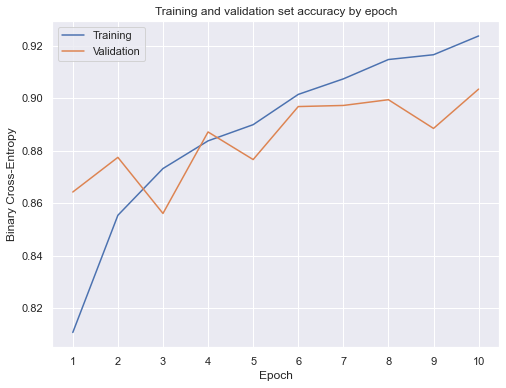

In [67]:
plot_model_performance(glove_model)

In [68]:
pred_glove = glove_model.predict(X_test_pad).flatten() # flatten from 2d to 1d array
pred_glove = pd.Series(pred_glove).apply(lambda x: 1 if x > 0.5 else 0)
metrics_dict['glove_lstm'] = metrics(y_test, pred_glove)
print(metrics_dict['glove_lstm'])

{'accuracy': 0.8956, 'sensitivity': 0.9236, 'specificity': 0.8303, 'precision': 0.8737, 'f1': 0.898, 'roc_auc': 0.8958}


Explanation..

### fastText embeddings

#### Embedding dictionary and embedding matrix

In [69]:
fast_vector_dims = 300
fast_embedding_dict = get_word_embeddings('fasttext')
fast_embedding_matrix = create_embedding_matrix(fast_embedding_dict, word_index, fast_vector_dims)

100%|██████████| 29444/29444 [00:00<00:00, 408183.32it/s]

Embedding dictionary contains 999,995 unique entries


#### Overlap between X_train and fastText file

In [70]:
intersection_train = [i for i in word_index.keys() if i in fast_embedding_dict.keys()]
intersection_test = [i for i in word_index_test.keys() if i in fast_embedding_dict.keys()]

print('Share of overlapping words in X_train: {}%'.format(round((len(intersection_train)/len(word_index)*100), 1)))
print('Share of overlapping words in X_test: {}%'.format(round((len(intersection_test)/len(word_index_test)*100), 1)))

Share of overlapping words in X_train: 80.5%
Share of overlapping words in X_test: 87.5%


Explanation..

#### Train a model using fastText embeddings

In [71]:
clear_session()

fast_model = Sequential()

fast_model.add(Embedding(input_dim=len(word_index)+1, 
                  output_dim=fast_vector_dims,
                  input_length=max_words_sequence, 
                  embeddings_initializer=Constant(fast_embedding_matrix),
                  trainable=False))

fast_model.add(Bidirectional(LSTM(units=128, dropout=0.4, 
               recurrent_dropout=0.3, return_sequences=True)))

fast_model.add(GlobalMaxPool1D())

fast_model.add(Dropout(0.3))

fast_model.add(Dense(64, activation='relu'))

fast_model.add(Dropout(0.2))

# Output layer
fast_model.add(Dense(1, activation='sigmoid'))

# Compile model
fast_model.compile(loss='binary_crossentropy', 
     optimizer=Adam(learning_rate=0.001), 
     metrics=['accuracy'])

In [72]:
fast_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1341, 300)         8833500   
_________________________________________________________________
bidirectional (Bidirectional (None, 1341, 256)         439296    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [73]:
fast_hist = fast_model.fit(X_train_pad, 
              y_train, 
              batch_size=64, 
              validation_split=0.25,
              verbose=2,
              epochs=10,
              use_multiprocessing=True,
              callbacks=[EarlyStopping(patience=2, restore_best_weights=True)])

Train on 35625 samples, validate on 11875 samples
Epoch 1/10


/Users/josephking/PythonVirtualEnv/IMDB_movie_sentiment/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


35625/35625 - 2147s - loss: 0.4123 - accuracy: 0.8068 - val_loss: 0.3322 - val_accuracy: 0.8612
Epoch 2/10
35625/35625 - 2150s - loss: 0.3290 - accuracy: 0.8600 - val_loss: 0.3010 - val_accuracy: 0.8747
Epoch 3/10
35625/35625 - 2151s - loss: 0.3068 - accuracy: 0.8702 - val_loss: 0.2944 - val_accuracy: 0.8787
Epoch 4/10
35625/35625 - 2147s - loss: 0.2927 - accuracy: 0.8758 - val_loss: 0.2742 - val_accuracy: 0.8862
Epoch 5/10
35625/35625 - 2202s - loss: 0.2719 - accuracy: 0.8862 - val_loss: 0.2631 - val_accuracy: 0.8924
Epoch 6/10
35625/35625 - 2151s - loss: 0.2648 - accuracy: 0.8900 - val_loss: 0.2530 - val_accuracy: 0.8984
Epoch 7/10
35625/35625 - 2153s - loss: 0.2510 - accuracy: 0.8956 - val_loss: 0.2593 - val_accuracy: 0.8938
Epoch 8/10
35625/35625 - 2105s - loss: 0.2419 - accuracy: 0.8997 - val_loss: 0.2577 - val_accuracy: 0.8947


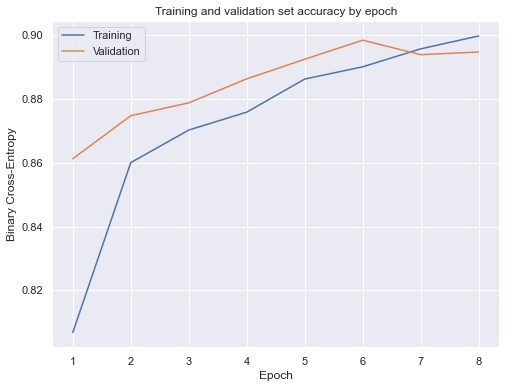

In [74]:
plot_model_performance(fast_model)

In [75]:
pred_fast = fast_model.predict(X_test_pad).flatten() # flatten from 2d to 1d array
pred_fast = pd.Series(pred_fast).apply(lambda x: 1 if x > 0.5 else 0)
metrics_dict['fast_lstm'] = metrics(y_test, pred_fast)
print(metrics_dict['fast_lstm'])

{'accuracy': 0.8948, 'sensitivity': 0.8906, 'specificity': 0.9157, 'precision': 0.8971, 'f1': 0.8938, 'roc_auc': 0.8948}


Explanation..

### Word embeddings with highest test accuracy

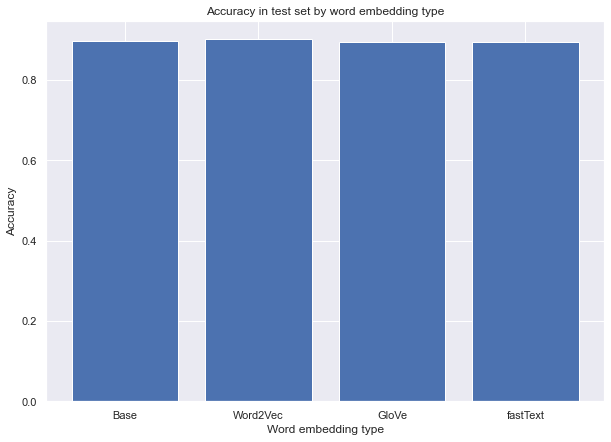

In [76]:
plt.close()
x = ['Base', 'Word2Vec', 'GloVe', 'fastText']
x_pos = [i for i, _ in enumerate(x)]
y = [metrics_dict['base_lstm']['accuracy'], metrics_dict['w2v_lstm']['accuracy'], 
     metrics_dict['glove_lstm']['accuracy'], metrics_dict['fast_lstm']['accuracy']]
plt.figure(figsize=(10,7))
plt.bar(x, y)
plt.xlabel('Word embedding type')
plt.ylabel('Accuracy')
plt.title('Accuracy in test set by word embedding type')
plt.show()

### Validation set loss across by word embedding type

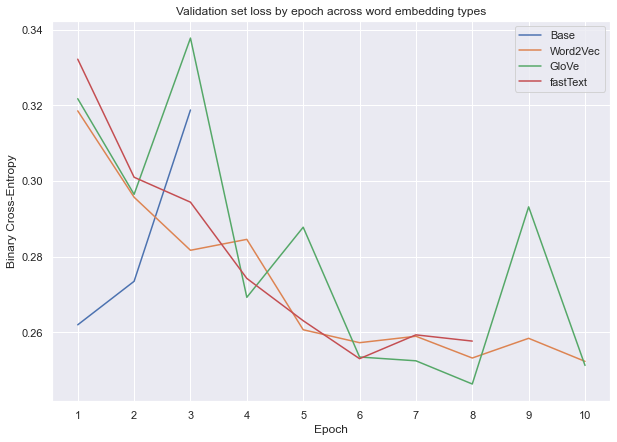

In [77]:
plt.figure(figsize=(10,7))
plt.plot(range(1,len(base_hist.history['val_loss'])+1), base_hist.history['val_loss'], label='Base')
plt.plot(range(1,len(w2v_hist.history['val_loss'])+1), w2v_hist.history['val_loss'], label='Word2Vec')
plt.plot(range(1,len(glove_hist.history['val_loss'])+1), glove_hist.history['val_loss'], label='GloVe')
plt.plot(range(1,len(fast_hist.history['val_loss'])+1), fast_hist.history['val_loss'], label='fastText')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy")
plt.title("Validation set loss by epoch across word embedding types")
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.show()

# Conclusion

Explanation..